In [ ]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

##*1 Download the dataset*

In [ ]:
!unzip '/content/orl_dataset.zip'

Archive:  /content/orl_dataset.zip
  inflating: README                  
  inflating: s1/1.pgm                
  inflating: s1/10.pgm               
  inflating: s1/2.pgm                
  inflating: s1/3.pgm                
  inflating: s1/4.pgm                
  inflating: s1/5.pgm                
  inflating: s1/6.pgm                
  inflating: s1/7.pgm                
  inflating: s1/8.pgm                
  inflating: s1/9.pgm                
  inflating: s10/1.pgm               
  inflating: s10/10.pgm              
  inflating: s10/2.pgm               
  inflating: s10/3.pgm               
  inflating: s10/4.pgm               
  inflating: s10/5.pgm               
  inflating: s10/6.pgm               
  inflating: s10/7.pgm               
  inflating: s10/8.pgm               
  inflating: s10/9.pgm               
  inflating: s11/1.pgm               
  inflating: s11/10.pgm              
  inflating: s11/2.pgm               
  inflating: s11/3.pgm               
  inflating: s1

In [ ]:
data =[]
labels =[]
training_data=[]
training_labels=[]
test_data=[]
test_labels=[]

##*2. Generate the Data Matrix and the Label vector*

In [ ]:
# Generate the Data Matrix and the Label vector

def read_data():
  id = 1
  for id in range(1,41):
    for count in range(1,11) :
      image = Image.open('s'+str(id)+'/'+str(count)+'.pgm')
      imgarr = img_to_array(image)
      imgarr = np.resize(imgarr,(10304))
      data.append(imgarr)
      labels.append(id)

##*3. Split the Dataset into Training and Test sets*

In [ ]:
 # Split the Dataset into Training and Test sets

def split_data():
  for i in range(400):
    if i%2==0:
      test_data.append(data[i])
      test_labels.append(labels[i])
    else:
      training_data.append(data[i])
      training_labels.append(labels[i])

In [ ]:
## main split
read_data()
split_data()

In [ ]:
print(len(data))
print(len(test_data))

400
200


In [ ]:

D_train=np.array(training_data)
D_test=np.array(test_data)
D_training_labels=np.array(training_labels)
D_test_labels=np.array(test_labels)



##*4. Dimensionality Reduction using PCA*

In [ ]:
def Pca(data):
  ## get cov 
  mean = np.mean(data, axis = 0)
  Z = data - mean
  covariance = (np.dot(Z.T,Z)) / Z.shape[0]
  # get eigenvalues and vec
  vals, vec = eigh(covariance)
  # Sort eigenvalues
  indices = np.abs(vals).argsort()[::-1]
  eig_val = vals[indices]
  # sort eigenvector across to eginvalues 
  eig_vec = vec[:,indices]
  return eig_val, eig_vec

In [ ]:
 # find the projection matrix U.

def getProjection (eig_val, eig_vec, D_train, alpha): 
  i = 0
  U = []
  sumeig = sum(eig_val)
  current_sum = 0
  # to get minimum number of eigenvectors which are good enough
  for x in range(len(eig_val)):
      if current_sum/sumeig < alpha:
        current_sum = current_sum + eig_val[x]
        i = i+1
  Ur = eig_vec[:, 0 : i]

  # Project the training set
  A = Ur.T.dot(D_train.T)
  A = A.T
  return A, Ur

##*5. Hyper-parameter Tuning*

In [ ]:
def proj_test (data, Ur):
  # Project the test set
  A = Ur.T.dot(data.T)
  A = A.T
  return A
 # Hyper-parameter Tuning
def solve(eig_val, eig_vec, D_train, training_y, test_X, test_y):
    alpha = [0.8, 0.85, 0.9, 0.95]
    K = [1, 3, 5, 7]
    # data_test = np.array(test_X)
    for i in range(len(alpha)):
        trianProj, Ur = getProjection(eig_val, eig_vec, D_train, alpha[i])
        acc = []
        testProj = proj_test(test_X, Ur)
        for j in K:
            knn = KNeighborsClassifier(n_neighbors=j)
            knn.fit(trianProj, training_y)
            acc.append(knn.score(testProj, test_y))

        print(acc)
        plt.plot(K, acc, label=alpha[i])
        plt.legend()

In [ ]:
# Calculate eigenvalues and eigenvectors
eig_val, eig_vec = Pca(D_train)

In [ ]:

# for one alpha value and K=1
def solveAlpha1(eig_val, eig_vec, D_train, training_y, test_X, test_y, alpha_value):
    K = 1
    reduced_training, Ur = getProjection(eig_val, eig_vec, D_train, alpha_value)
    acc = [] 
    reduced_testing = proj_test(test_X, Ur)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(reduced_training, training_y)
    acc.append(knn.score(reduced_testing, test_y)*100)

    print("Accuracy for alpha",alpha_value , "=",acc[0],"%")
    


In [ ]:
 # Accuracy for every value of alpha separately  for K=1

solveAlpha1(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels, 0.80)
solveAlpha1(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels, 0.85)
solveAlpha1(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels, 0.90)
solveAlpha1(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels, 0.95)

# When alpha increases , Accuracy incrseases . Here the results is nearly the same

Accuracy for alpha 0.8 = 93.0 %
Accuracy for alpha 0.85 = 94.0 %
Accuracy for alpha 0.9 = 94.5 %
Accuracy for alpha 0.95 = 93.5 %


In [ ]:

 # for one K value and different alphas
def solveK(eig_val, eig_vec, D_train, training_y, test_X, test_y, K_value):
    alpha = []
    # data_test = np.array(test_X)
    acc = []
    i = 0.5
    while (i < 1):
        reduced_training, Ur = getProjection(eig_val, eig_vec, D_train, i)
        reduced_testing = proj_test(test_X, Ur)
        knn = KNeighborsClassifier(n_neighbors=K_value)
        knn.fit(reduced_training, training_y)
        acc.append(knn.score(reduced_testing, test_y))
        alpha.append(i)
        i = i + 0.05

    print(acc)
    plt.plot(alpha, acc)
    plt.xlabel("alpha")
    plt.ylabel("acc")
    plt.title("relation at K= {}".format(K_value))
    plt.legend()

No handles with labels found to put in legend.


[0.865, 0.87, 0.905, 0.915, 0.92, 0.925, 0.93, 0.94, 0.945, 0.935]


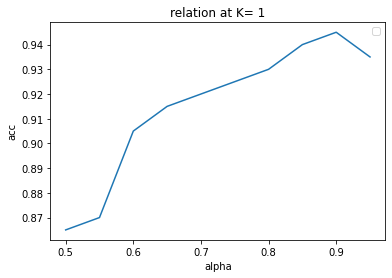

In [ ]:
solveK(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels,1)

In [ ]:
 
 # for one alpha value and K=[1,3,5,7]
 def solveAlpha(eig_val, eig_vec, D_train, training_y, test_X, test_y, alpha_value):
    K = [1,3,5,7]
    reduced_training, Ur = getProjection(eig_val, eig_vec, D_train, alpha_value)
    acc = [] 
    reduced_testing = proj_test(test_X, Ur)
    for j in K:
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(reduced_training, training_y)
        acc.append(knn.score(reduced_testing, test_y))

    print(acc)
    plt.plot(K, acc)
    plt.xlabel("K")
    plt.ylabel("acc")
    plt.title("relation at alpha= {}".format(alpha_value))

    plt.legend()

No handles with labels found to put in legend.


[0.93, 0.855, 0.805, 0.78]


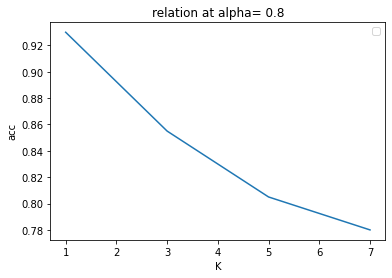

In [ ]:

 solveAlpha(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels, 0.80)
 

[0.93, 0.855, 0.805, 0.78]
[0.94, 0.855, 0.83, 0.775]
[0.945, 0.85, 0.815, 0.755]
[0.935, 0.845, 0.815, 0.74]


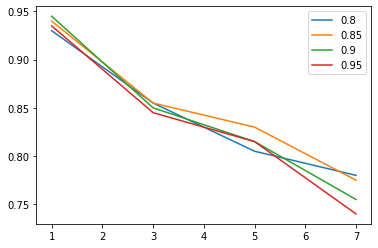

In [ ]:

#Plot (or tabulate) the performance measure (accuracy) against the K value.
solve(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels)

##*6. BONUS*

In [ ]:
#Bounes Split
read_data()
training_data, test_data, training_labels, test_labels = train_test_split(data, labels, train_size=0.7)

In [ ]:
print(len(data))
print(len(test_data))

400
120


[0.9416666666666667, 0.9416666666666667, 0.8666666666666667, 0.825]
[0.95, 0.9333333333333333, 0.875, 0.8166666666666667]
[0.95, 0.925, 0.8666666666666667, 0.8166666666666667]
[0.9416666666666667, 0.9166666666666666, 0.85, 0.8]


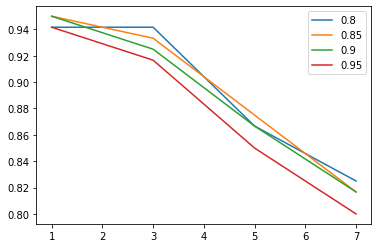

In [ ]:
#Plot (or tabulate) the performance measure (accuracy) against the K value.
solve(eig_val, eig_vec, D_train, D_training_labels, D_test, D_test_labels)